In [105]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView, shortest_path
from networkx.drawing.nx_agraph import graphviz_layout

from ic import simulate_cascade, observe_cascade, get_gvs, get_o2src_time, get_infection_time, gen_nontrivial_cascade
from utils import get_rank_index, extract_edges

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'balanced-tree'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 1.0

gvs = get_gvs(g, p, N2)
pos = graphviz_layout(gnx, root=0)

In [115]:
from steiner_tree_order import remove_redundant_edges_from_tree

In [108]:
from collections import defaultdict
def temporal_bfs(g, r, infection_times, source, obs_nodes, debug=False):
    queue = [r]
    t_lower = np.ones(g.num_vertices(), dtype=np.int32) * -1  # hidden nodes has lower bound -1
    t_lower[obs_nodes] = infection_times[obs_nodes]
    t_lower[r] = infection_times[obs_nodes].min() - 1
    visited = g.new_vertex_property('bool')
    visited.set_2d_array(np.zeros(g.num_vertices(), dtype=bool))
    tree = []

    obs_by_time = defaultdict(list)
    for o in obs_nodes:
        obs_by_time[infection_times[o]].append(o)
    obs_times = list(sorted(set(infection_times[obs_nodes])))

    useful_edges = []

    success = True
    for cur_t in obs_times:
        banned_nodes = {v for v in obs_nodes if infection_times[v] != cur_t}
        target_nodes = [v for v in obs_nodes if infection_times[v] == cur_t]
        
        if debug:
            print('current time = {}'.format(cur_t))
            print('targets {}'.format(target_nodes))
        targets_covered = False
        # cover nodes of level t
        while len(queue) > 0:
            if np.all(visited.a[target_nodes] == 1):
                if debug:
                    print('covered all targets')
                targets_covered = True
                break
            v = queue.pop(0)
            for u in g.vertex(v).all_neighbours():
                if u not in banned_nodes and visited[u] == 0:
                    if debug and u in target_nodes:                        
                        print('cover target {}'.format(u))
                    if debug:
                        print('add edge {}'.format((v, int(u))))
                    tree.append((v, int(u)))
                    visited[u] = True
                    queue.append(int(u))
        if targets_covered:
            if False:
                if debug and False:
                    print('update tree and visited table')                
                # remove redundant edges
                # construct the tree from used edges
                terminals = [o for o in obs_nodes if infection_times[o] <= cur_t]
                if debug:
                    print('terminals to cover: {}'.format(terminals))

                min_tree = remove_redundant_edges_from_tree(g, tree, r, terminals)
                if debug:
                    print('size of min tree: {}'.format(min_tree.num_edges()))
                tree = extract_edges(min_tree)
                if debug:
                    print('current tree edges {}'.format(tree))

                # update visited table
                visited.set_2d_array(np.zeros(g.num_vertices()))
                covered_nodes = {u for nodes in tree for u in nodes}
                for v in covered_nodes:
                    visited[g.vertex(v)] = 1
                queue = list(covered_nodes)
            continue
        else:
            if debug:
                print('failed to cover targets')
            success = False
            break
    if success:                    
        return remove_redundant_edges_from_tree(g, tree, r, obs_nodes)
    else:
        return None

In [109]:
print('source={}'.format(source))
tree = temporal_bfs(g, source, infection_times, source, obs_nodes, debug=False)
len(extract_edges(tree))

source=51


9

In [95]:
debug = False
r = 42
def temporal_bfs(g, r, infection_times, source, obs_nodes, debug=False):
    """return the tree covering obs_nodes"""
    queue = [r]
    t_lower = np.ones(g.num_vertices(), dtype=np.int32) * -1  # hidden nodes has lower bound -1
    t_lower[obs_nodes] = infection_times[obs_nodes]
    t_lower[r] = infection_times[obs_nodes].min() - 1
    visited = g.new_vertex_property('bool')
    visited.set_2d_array(np.zeros(g.num_vertices(), dtype=bool))
    tree = []

    obs_by_time = defaultdict(list)
    for o in obs_nodes:
        obs_by_time[infection_times[o]].append(o)
    obs_times = list(sorted(set(infection_times[obs_nodes])))

    while len(queue) > 0 and np.any(visited.a[obs_nodes] == 0):
        v = queue.pop(0)

        if debug:
            print('visiting {}'.format(v))

        visited[g.vertex(v)] = True
        for u in g.vertex(v).all_neighbours():
            if debug:
                print('trying its nbr {}'.format(u))

            if visited[u] == 0:
                if debug:
                    print('{} is not visited'.format(u))
                    print('t_l[u]={}, t_l[v]={}'.format(t_lower[u], t_lower[v]))
                u = int(u)
                visitable = False

                if t_lower[u] > t_lower[v]:
                    if debug:
                        print('first case')
                    visitable = True

                if t_lower[u] == -1:
                    if debug:
                        print('second case')
                    visitable= True
                    t_lower[u] = t_lower[v]

                if visitable:
                    if debug:
                        print('add {} to queue'.format(u))
                    queue.append(u)
                    tree.append((v, u))
                    visited[g.vertex(u)] = True
    if np.any(visited.a[obs_nodes] == 0):
        # some terminal is uncovered
        return False
    else:
        efilt = g.new_edge_property('bool')
        for u, v in tree:
            efilt[g.edge(u, v)] = True
        
        min_tree_efilt = g.new_edge_property('bool')
        tree = GraphView(g, efilt=efilt)
        for o in obs_nodes:
            _, edge_list = shortest_path(tree, source=tree.vertex(r), target=tree.vertex(o))
            for e in edge_list:
                min_tree_efilt[e] = True
        min_tree = GraphView(g, efilt=min_tree_efilt) 
        return min_tree

In [120]:
while True:
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, return_tree=True)
    r2tree_size = np.ones(g.num_vertices()) * 1000
    cands = set(np.arange(g.num_vertices())) - set(obs_nodes)
    for r in tqdm(cands):
        tree = temporal_bfs(g, r, infection_times, source, obs_nodes)
        if tree:
            r2tree_size[r] = tree.num_edges()
    if get_rank_index(-r2tree_size, source) != 0.0:
        break

 75%|███████▍  | 44/59 [00:00<00:00, 104.80it/s]


KeyboardInterrupt: 

In [111]:
winner = np.argmin(r2tree_size)

In [112]:
get_rank_index(-r2tree_size, source)

0.0

In [113]:
tree_source = temporal_bfs(g, source, infection_times, source, obs_nodes, debug=False)
tree_best = temporal_bfs(g, winner, infection_times, source, obs_nodes, debug=False)

<IPython.core.display.Javascript object>


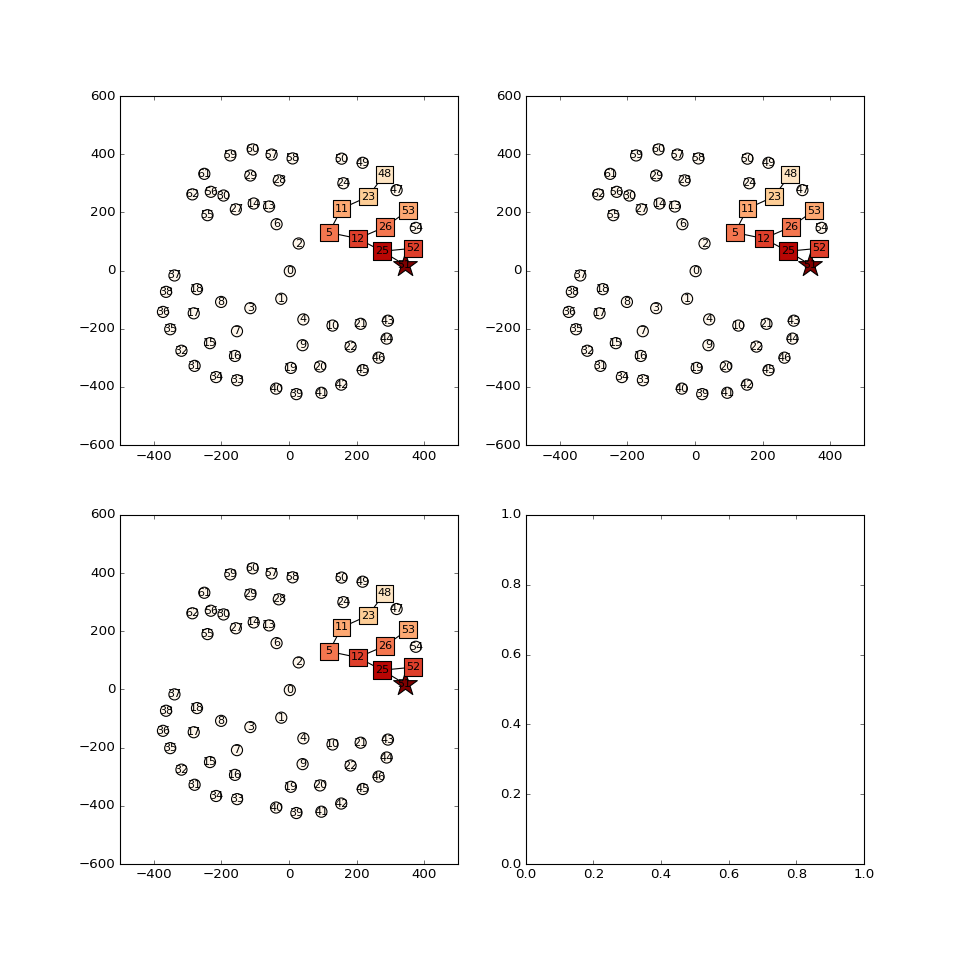

In [114]:
from plot_utils import plot_snapshot

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True, ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, get_infection_time(tree_source, source), queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(tree_source))
plot_snapshot(gnx, pos, get_infection_time(tree_best, winner), queried_nodes=obs_nodes, source_node=winner, with_labels=True,
              ax=ax[1, 0],
              edges=extract_edges(tree_best))